SETUP

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import qkeras
from qkeras import *
from qkeras.utils import _add_supported_quantized_objects
co = {}
_add_supported_quantized_objects(co)
import hls4ml
from QDenseBatchnorm import QDenseBatchnorm
import hls4ml.utils
import hls4ml.converters

def loss(y_true, y_pred, choice):
    if choice == 'mse':
        loss = np.mean((y_true - y_pred)**2, axis = (1,2,3))
        return loss

2026-02-09 16:22:16.647241: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-09 16:22:16.735534: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-02-09 16:22:16.735590: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-02-09 16:22:16.737497: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-02-09 16:22:16.752302: I tensorflow/core/platform/cpu_feature_guar

In [2]:
teacher = keras.models.load_model('../saved_models/teacher_tiles40X192_sample')
student_test = qkeras.utils.load_qmodel('../saved_models/v1_12X12_40X192')

config = hls4ml.utils.config_from_keras_model(student_test, backend='Vitis', 
                                              default_precision='fixed<32,16>',
                                              granularity='name')

hls_model = hls4ml.converters.convert_from_keras_model(student_test,
                                                       hls_config=config,
                                                       io_type='io_parallel',
                                                       backend = 'Vitis',
                                                       output_dir=f'v1_12X12_40X192_check')

hls_model.compile()

/mnt/storage1/RAD/.conda/envs/hls_RAD/lib/python3.9/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(
/mnt/storage1/RAD/.conda/envs/hls_RAD/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Interpreting Model
Topology:
Layer name: inputs_, layer type: InputLayer, input shapes: [[None, 288]], output shape: [None, 288]
Layer name: dense1, layer type: QDenseBatchnorm, input shapes: [[None, 288]], output shape: [None, 16]
Layer name: relu1, layer type: Activation, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: dense2, layer type: QDense, input shapes: [[None, 16]], output shape: [None, 1]
Layer name: outputs, layer type: Activation, input shapes: [[None, 1]], output shape: [None, 1]
Interpreting Model
Topology:
Layer name: inputs_, layer type: InputLayer, input shapes: [[None, 288]], output shape: [None, 288]
Layer name: dense1, layer type: QDenseBatchnorm, input shapes: [[None, 288]], output shape: [None, 16]
Layer name: relu1, layer type: Activation, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: dense2, layer type: QDense, input shapes: [[None, 16]], output shape: [None, 1]
Layer name: outputs, layer type: Activation, input shapes: [[Non

In [3]:
X = np.load("../data/bnb_WithWire_00_batch_00_40X192.npy")
X_flat = X.reshape((X.shape[0],-1))

X_predict_teacher = teacher.predict(X)
X_loss_teacher = loss(X, X_predict_teacher, 'mse')
Y = student_test.predict(X_flat).reshape(len(X_loss_teacher))

fake_hls4ml_pred, hls4ml_trace = hls_model.trace(X)

y_predict_hls4ml_q = hls_model.predict(X_flat).reshape(len(X_loss_teacher))

np.savetxt("student_qkeras_prediction.dat", Y, fmt="%.8f", delimiter=" ")
np.savetxt("student_hls_prediction.dat", y_predict_hls4ml_q, fmt="%.8f", delimiter=" ")

61440/61440 [==============================] - 57s 925us/step
Recompiling myproject with tracing
Writing HLS project
Done


Interpreting Model
Topology:
Layer name: inputs_, layer type: InputLayer, input shapes: [[None, 288]], output shape: [None, 288]
Layer name: dense1, layer type: QDenseBatchnorm, input shapes: [[None, 288]], output shape: [None, 16]
Layer name: relu1, layer type: Activation, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: dense2, layer type: QDense, input shapes: [[None, 16]], output shape: [None, 1]
Layer name: outputs, layer type: Activation, input shapes: [[None, 1]], output shape: [None, 1]
Creating HLS model
Profiling weights (before optimization)
Weights for dense2 are only zeros, ignoring.
Profiling weights (final / after optimization)
Weights for dense2 are only zeros, ignoring.


(<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 None,
 None)

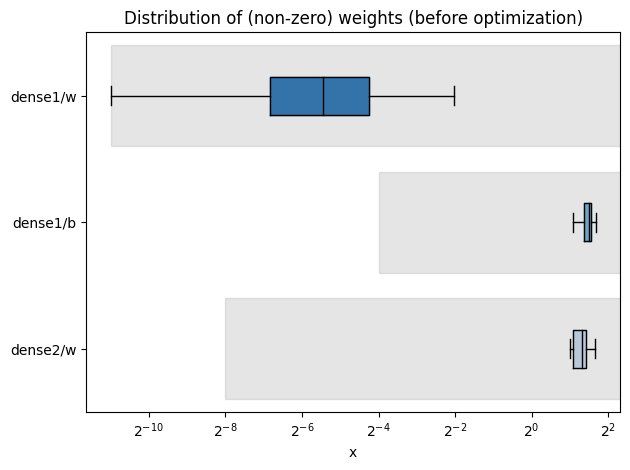

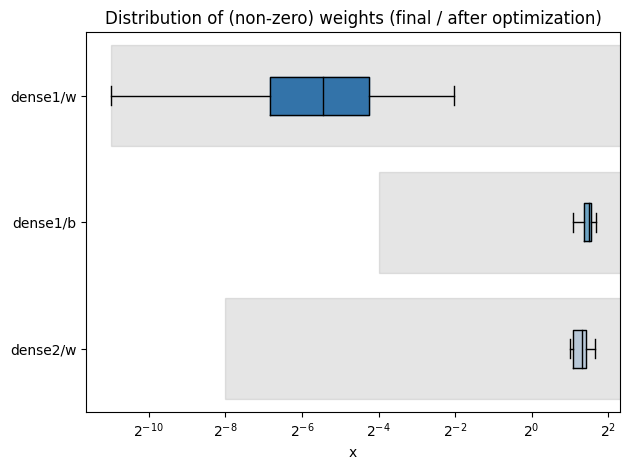

In [4]:
hls4ml.model.profiling.numerical(model=student_test, hls_model=hls_model)

In [5]:
for i, layer in enumerate(student_test.layers):
    print(layer)
    weights = layer.get_weights()
    for j,w in enumerate(weights):
        file_name = f"layer_{i}_weights_{j}.txt"
        if i!=1 and j!=4:
            np.savetxt(file_name, w, delimiter="\n")

In [6]:
hls_model.build(csim=False)


****** Vitis HLS - High-Level Synthesis from C, C++ and OpenCL v2023.1 (64-bit)
  **** SW Build 3854077 on May  4 2023
  **** IP Build 3864474 on Sun May  7 20:36:21 MDT 2023
  **** SharedData Build 3865790 on Sun May 07 13:33:03 MDT 2023
    ** Copyright 1986-2022 Xilinx, Inc. All Rights Reserved.
    ** Copyright 2022-2023 Advanced Micro Devices, Inc. All Rights Reserved.

source /scratch/am_vitis/Vitis_HLS/2023.1/scripts/vitis_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/scratch/am_vitis/Vitis_HLS/2023.1/bin/unwrapped/lnx64.o/vitis_hls'
INFO: [HLS 200-10] For user 'RAD' on host 'cleopatra.nevis.columbia.edu' (Linux_x86_64 version 3.10.0-1160.31.1.el7.x86_64) on Mon Feb 09 16:35:50 EST 2026
INFO: [HLS 200-10] On os "CentOS Linux release 7.9.2009 (Core)"
INFO: [HLS 200-10] In directory '/mnt/storage1/RAD/RAD_FPGA/notebooks/v1_12X12_40X192_check'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-1510] Running: open_project myproject_prj 
INFO: [HLS 200-10] Creating and opening p

{'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '4.419',
  'BestLatency': '6',
  'WorstLatency': '6',
  'IntervalMin': '1',
  'IntervalMax': '1',
  'DSP': '5329',
  'FF': '127634',
  'LUT': '286856',
  'BRAM_18K': '0',
  'URAM': '0',
  'AvailableBRAM_18K': '5376',
  'AvailableDSP': '12288',
  'AvailableFF': '3456000',
  'AvailableLUT': '1728000',
  'AvailableURAM': '1280'}}